# Imports

In [78]:
# for importing code
import sys, os

module_path = os.path.abspath(os.path.join("..", "src"))
if module_path not in sys.path:
    print(f"Adding {module_path} to sys.path")
    sys.path.append(module_path)

In [79]:
import pandas as pd
from constants import PROJECT_ROOT

# created by: uv run python src/classify_twitter_posts.py --model anthropic/claude-sonnet-4 --temperature 0.1 --n-samples 750 --min-chars 50 --results_filename twitter_posts_classified
path = f"{PROJECT_ROOT}/outputs/500_samples_ihra_half_antisemitic_no_urls/twitter_posts_classified_IHRA_2025-09-11-H:11-M:24.csv"

df = pd.read_csv(path)
df = df.rename(columns={"biased": "is_antisemitic"})
df

,original_index,text,is_antisemitic,keyword,prediction,description,model,max_tokens,temperature,usage
0,113,"Following query, The Prime Minister’s Office ...",0,Israel,False,This text is a factual report about Israel's o...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3812, 'completion_tokens': 7..."
1,848,"To the Jews, crucifixion is a stumbling block....",0,Jews,False,This text appears to be a religious commentary...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3821, 'completion_tokens': 9..."
2,346,Lots of American Jews feeling no Love for Righ...,0,Jews,False,The text criticizes the Israeli government as ...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3793, 'completion_tokens': 1..."
3,121,"On a 1 to 10 scale, how important is the Israe...",0,Israel,False,This text is a neutral question asking for an ...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3799, 'completion_tokens': 7..."
4,734,"Hang on, is it NOT common knowledge amongst pp...",0,Jews,False,This text discusses theological similarities b...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3796, 'completion_tokens': 6..."
...,...,...,...,...,...,...,...,...,...,...
495,636,A lot of y’all ladies be talkin cash shit but...,1,Jews,True,The text uses 'jews' as a derogatory term or i...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3784, 'completion_tokens': 9..."
496,1375,the WHAT now??? do you not know that there are...,1,Jews,False,The text expresses support for Palestinian fre...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3812, 'completion_tokens': 8..."
497,606,"He said Adelson, not Jews. Adelson has given $...",1,Jews,False,The text refers specifically to Adelson as an ...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3809, 'completion_tokens': 6..."
498,408,respected his God and father John 20:17? Far t...,1,Jews,True,The text makes stereotypical allegations about...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3826, 'completion_tokens': 1..."


# Cost

In [80]:
import json
import pandas as pd
import ast


# Try different parsing methods
def safe_parse_usage(usage_str):
    try:
        # Try JSON first
        return json.loads(usage_str)
    except Exception:
        try:
            # Try ast.literal_eval for Python dict strings
            return ast.literal_eval(usage_str)
        except Exception:
            try:
                # Try eval as last resort (if it's a Python dict)
                return eval(usage_str)
            except Exception:
                return None


def print_costs(df_origin):
    df = df_origin.copy()
    # Parse the usage column
    df["usage_parsed"] = df["usage"].apply(safe_parse_usage)

    # Check how many failed to parse
    failed_count = df["usage_parsed"].isnull().sum()
    print(f"Failed to parse: {failed_count} rows out of {len(df)}")

    # Extract token counts (handle None values)
    df["prompt_tokens"] = df["usage_parsed"].apply(
        lambda x: x["prompt_tokens"] if x else 0
    )
    df["completion_tokens"] = df["usage_parsed"].apply(
        lambda x: x["completion_tokens"] if x else 0
    )
    df["total_tokens"] = df["usage_parsed"].apply(
        lambda x: x["total_tokens"] if x else 0
    )

    # Calculate totals
    total_prompt_tokens = df["prompt_tokens"].sum()
    total_completion_tokens = df["completion_tokens"].sum()
    total_tokens = df["total_tokens"].sum()

    # Claude Sonnet 4 pricing: $3/M input, $15/M output
    input_cost = (total_prompt_tokens / 1_000_000) * 3
    output_cost = (total_completion_tokens / 1_000_000) * 15
    total_cost = input_cost + output_cost

    print(f"Total Prompt Tokens: {total_prompt_tokens:,}")
    print(f"Total Completion Tokens: {total_completion_tokens:,}")
    print(f"Total Tokens: {total_tokens:,}")
    print("\nCost Breakdown:")
    print(f"Input Cost: ${input_cost:.4f}")
    print(f"Output Cost: ${output_cost:.4f}")
    print(f"Total Cost: ${total_cost:.4f}")


print_costs(df)
print("\n")

Failed to parse: 2 rows out of 500
Total Prompt Tokens: 1,901,120
Total Completion Tokens: 44,005
Total Tokens: 1,945,125

Cost Breakdown:
Input Cost: $5.7034
Output Cost: $0.6601
Total Cost: $6.3634




# EDA

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   original_index  500 non-null    int64  
 1   text            500 non-null    object 
 2   is_antisemitic  500 non-null    int64  
 3   keyword         500 non-null    object 
 4   prediction      500 non-null    object 
 5   description     500 non-null    object 
 6   model           500 non-null    object 
 7   max_tokens      500 non-null    int64  
 8   temperature     500 non-null    float64
 9   usage           498 non-null    object 
dtypes: float64(1), int64(3), object(6)
memory usage: 39.2+ KB


In [82]:
df["prediction"].value_counts()

prediction
True         255
False        243
LLM_ERROR      2
Name: count, dtype: int64

In [83]:
df = df[df["prediction"].isin(["True", "False"])]

# convert prediction to int:
df["prediction"] = df["prediction"].map({"True": 1, "False": 0})

/var/folders/yc/2ky7xhns66nbhnjkcrs4p1nw0000gp/T/ipykernel_29899/2660278532.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["prediction"] = df["prediction"].map({"True": 1, "False": 0})


/var/folders/yc/2ky7xhns66nbhnjkcrs4p1nw0000gp/T/ipykernel_29899/1362021139.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_clean"] = df["text"].apply(clean_text)


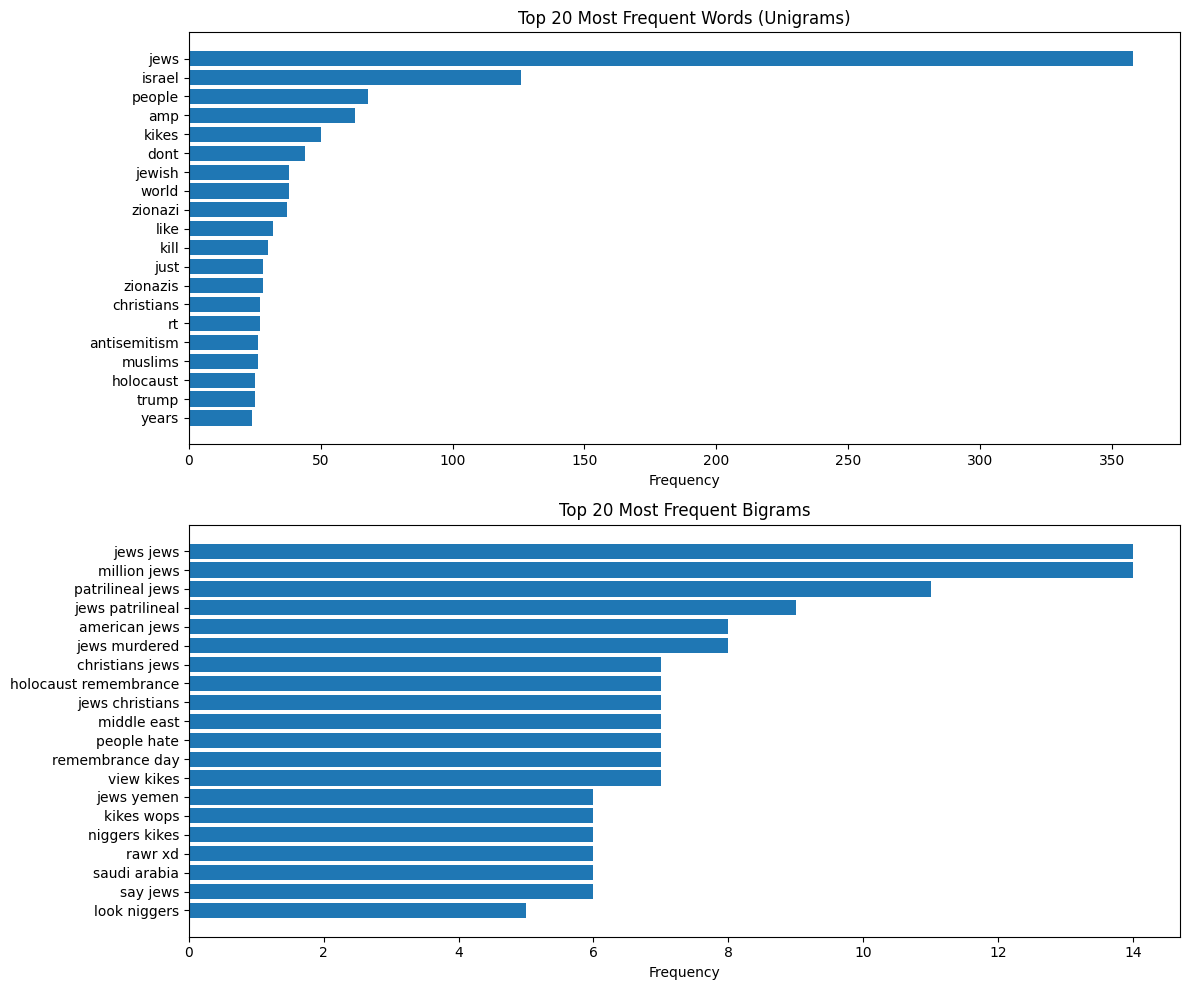

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import CountVectorizer


# Clean and prepare text data
def clean_text(text):
    # Convert to lowercase, remove URLs, mentions, and special characters
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\s+", " ", text)  # Remove extra spaces
    return text.strip()


# Clean all text
df["text_clean"] = df["text"].apply(clean_text)

# Get most frequent words (unigrams)
vectorizer_unigrams = CountVectorizer(
    stop_words="english", max_features=20, ngram_range=(1, 1)
)
unigram_matrix = vectorizer_unigrams.fit_transform(df["text_clean"])
unigram_counts = unigram_matrix.sum(axis=0).A1
unigram_freq = [
    (word, count)
    for word, count in zip(vectorizer_unigrams.get_feature_names_out(), unigram_counts)
]
unigram_freq = sorted(unigram_freq, key=lambda x: x[1], reverse=True)

# Get most frequent bigrams
vectorizer_bigrams = CountVectorizer(
    stop_words="english", max_features=20, ngram_range=(2, 2)
)
bigram_matrix = vectorizer_bigrams.fit_transform(df["text_clean"])
bigram_counts = bigram_matrix.sum(axis=0).A1
bigram_freq = [
    (word, count)
    for word, count in zip(vectorizer_bigrams.get_feature_names_out(), bigram_counts)
]
bigram_freq = sorted(bigram_freq, key=lambda x: x[1], reverse=True)

# Create plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot unigrams
words, counts = zip(*unigram_freq)
ax1.barh(range(len(words)), counts)
ax1.set_yticks(range(len(words)))
ax1.set_yticklabels(words)
ax1.set_xlabel("Frequency")
ax1.set_title("Top 20 Most Frequent Words (Unigrams)")
ax1.invert_yaxis()

# Plot bigrams
bigrams, bigram_counts = zip(*bigram_freq)
ax2.barh(range(len(bigrams)), bigram_counts)
ax2.set_yticks(range(len(bigrams)))
ax2.set_yticklabels(bigrams)
ax2.set_xlabel("Frequency")
ax2.set_title("Top 20 Most Frequent Bigrams")
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

# Prediction stats


len(y_true_all)=498, len(y_pred_all)=498
len(y_true)=498, len(y_pred)=498


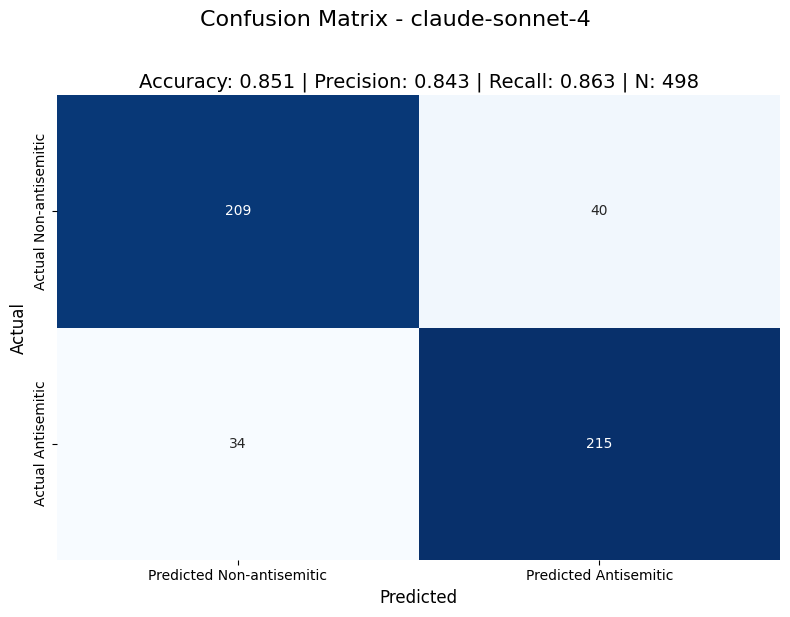

Confusion Matrix Results:
Accuracy: 0.8514
Precision: 0.8431
Recall: 0.8635
Samples: 498


In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    accuracy_score,
)

PRED_COL = "prediction"  # Single prediction column
TRUTH_COL = "is_antisemitic"


def coerce_to_binary(s: pd.Series) -> pd.Series:
    """
    Convert common truthy/falsey values to {0,1}, keep unknowns as NaN.
    Handles bools, 0/1, and strings like 'true','false','yes','no'.
    """
    if s.dtype == bool:
        return s.astype(int)
    if pd.api.types.is_numeric_dtype(s):
        return pd.to_numeric(s, errors="coerce").round().clip(0, 1).astype("Int64")
    # strings
    true_vals = {"true", "1", "yes", "y", "t", "antisemitic"}
    false_vals = {"false", "0", "no", "n", "f", "non-antisemitic", "not antisemitic"}
    ss = s.astype(str).str.strip().str.lower()
    mapped = ss.map(
        lambda x: 1 if x in true_vals else (0 if x in false_vals else np.nan)
    )
    return pd.Series(mapped, index=s.index, dtype="float")


def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    return cm, precision, recall, accuracy


# Prepare truth and prediction
y_true_all = coerce_to_binary(df[TRUTH_COL])
y_pred_all = coerce_to_binary(df[PRED_COL])

print(f"{len(y_true_all)=}, {len(y_pred_all)=}")
# Align and drop rows with NaNs in either
mask = (~pd.isna(y_true_all)) & (~pd.isna(y_pred_all))
y_true = y_true_all[mask].astype(int)
y_pred = y_pred_all[mask].astype(int)

print(f"{len(y_true)=}, {len(y_pred)=}")

cm, precision, recall, accuracy = calculate_metrics(y_true, y_pred)

# Get model name if available
model_name = None
if "model" in df.columns and df["model"].notna().any():
    try:
        model_name = df["model"].dropna().iloc[0].split("/")[-1]
    except Exception:
        model_name = df["model"].dropna().iloc[0]

# Plot confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["Predicted Non-antisemitic", "Predicted Antisemitic"],
    yticklabels=["Actual Non-antisemitic", "Actual Antisemitic"],
    ax=ax,
)

title_bits = [
    f"Accuracy: {accuracy:.3f}",
    f"Precision: {precision:.3f}",
    f"Recall: {recall:.3f}",
    f"N: {int(mask.sum())}",
]
ax.set_title(" | ".join(title_bits), fontsize=14)
ax.set_xlabel("Predicted", fontsize=12)
ax.set_ylabel("Actual", fontsize=12)

if model_name:
    fig.suptitle(f"Confusion Matrix - {model_name}", y=1.02, fontsize=16)

plt.tight_layout()
plt.show()

# Print metrics
print(f"Confusion Matrix Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Samples: {int(mask.sum())}")

In [86]:
# create a column error type:
def classify_error(row):
    if pd.isna(row[TRUTH_COL]) or pd.isna(row[PRED_COL]):
        return "unknown"
    elif row[TRUTH_COL] == 1 and row[PRED_COL] == 1:
        return "true_positive"
    elif row[TRUTH_COL] == 0 and row[PRED_COL] == 0:
        return "true_negative"
    elif row[TRUTH_COL] == 0 and row[PRED_COL] == 1:
        return "false_positive"
    elif row[TRUTH_COL] == 1 and row[PRED_COL] == 0:
        return "false_negative"
    else:
        return "unknown"


df["error_type"] = df.apply(classify_error, axis=1)
df["error_type"].value_counts()

/var/folders/yc/2ky7xhns66nbhnjkcrs4p1nw0000gp/T/ipykernel_29899/2289298042.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["error_type"] = df.apply(classify_error, axis=1)


error_type
true_positive     215
true_negative     209
false_positive     40
false_negative     34
Name: count, dtype: int64

In [98]:
from utils import load_trainset


def load_trainset() -> pd.DataFrame:
    """Load the original training dataset from CSV."""
    train_path = f"{PROJECT_ROOT}/datasets/train_test_datasets/train.csv"
    return pd.read_csv(train_path)


original_train = load_trainset()
original_train["original_index"] = original_train.index

df_full = pd.merge(
    df,
    original_train[["original_index", "ID", "CreateDate", "Username", "Text"]].rename(
        columns={"Text": "original_text"}
    ),
    how="left",
    on="original_index",
)

In [104]:
relevant_cols = [
    "text",
    TRUTH_COL,
    PRED_COL,
    "original_index",
    "ID",
    "CreateDate",
    "Username",
    "description",
    "keyword",
    "original_text",
    "error_type",
]
df_full[relevant_cols].sample(df_full.shape[0], random_state=42).to_csv(
    f"{PROJECT_ROOT}/outputs/500_samples_ihra_half_antisemitic_no_urls/error_analysis.csv",
    index=False,
)

In [ ]:
# Get error counts by keyword
error_counts = (
    df[df["error_type"].isin(["False Negative", "False Positive"])]
    .groupby("keyword")["error_type"]
    .value_counts()
)

# Get total keyword counts
keyword_totals = df["keyword"].value_counts()

# Normalize error counts by keyword totals
error_rates = error_counts / keyword_totals

print("Error rates (normalized by keyword frequency):")
print(error_rates)
print()
print("Error counts (absolute):")
print(error_counts)
print()
print("Keyword totals:")
print(keyword_totals)

In [67]:
# Get total keyword counts
keyword_totals = df["keyword"].value_counts()

# Normalize error counts by keyword totals
error_rates = error_counts / keyword_totals

print("Error rates (normalized by keyword frequency):")
print(error_rates)
print()
print("Error counts (absolute):")
print(error_counts)
print()
print("Keyword totals:")
print(keyword_totals)

keyword
Jews       294
Israel      90
ZioNazi     64
Kikes       50
Name: count, dtype: int64